<a href="https://colab.research.google.com/github/shahin1009/ModelOrderReduction/blob/main/Lab_3_Reduced_Basis_Part_1_(trace).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
try:
     from dlroms import*
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

# **Lab 3 - Reduced Basis method (Part 1: stationary PDEs)**

The Reduced Basis (RB) method is an intrusive model order reduction technique for parametrized PDEs. Consider a stationary **linear** PDE depending on a parameter $\boldsymbol{\mu}\in\mathbb{R}^{p}$. Discretizing the problem via the Finite Element Method (FEM) yields a linear system of the form

$$\begin{equation}\tag{1}\mathbf{A}_{\boldsymbol{\mu}}\mathbf{u}=\mathbf{f}_{\boldsymbol{\mu}},\end{equation}$$

where $\mathbf{A}_{\boldsymbol{\mu}}\in\mathbb{R}^{N_{h}\times N_{h}}$ and $\mathbf{f}_{\boldsymbol{\mu}}\in\mathbb{R}^{N_{h}}$ are parameter dependent. Here, $N_{h}$ is the dimension of the underlying Finite Element space $V_{h}$.
</br></br>
**Eq. (1) is referred to as the Full Order Model (FOM)**. A FOM solver is a suitable algorithm that, given $\boldsymbol{\mu}$ computes the solution $\mathbf{u}=\mathbf{u}_\boldsymbol{\mu}$ of (1).
</br>
</br>
The idea behind model order reduction (or "reduced order modeling"), is that, once we have solved (1) several times, we may note that PDE solutions tend to exhbit recurring patterns, which may allow us to take suitable short-cuts when computing new solutions. Specifically, in the RB approach, we ask ourselves the following question:
</br></br>

<p align="center"><i>Is it worth solving the PDE in the whole FOM space?
</br>Maybe there is a better basis, specifically tailored for this parametrized problem...!</i></p></br>

**In this lab, we shall explore this concept by re-visiting the parametrized cookie problem (see Lab. 2, Ex. 5).**

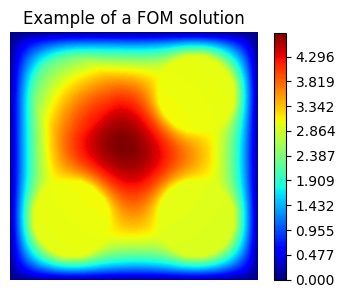

In [ ]:
from dlroms.testcases.cookies import Vh, FOMsolver

mu0 = np.array([1, 0.1, 1, 1])
u0 = FOMsolver(mu0)

plt.figure(figsize = (4, 4))
fe.plot(u0, Vh, colorbar = True)
plt.title("Example of a FOM solution")
plt.show()

In [ ]:
# Data generation [...]
np.random.seed(0)
muList =[]
uList =[]

nsim = 100

for j in range(nsim):
  mu = np.random.rand(4)
  uj = FOMsolver(mu)
  muList.append(mu)
  uList.append(uj)

mu = np.stack(muList)
u = np.stack(uList)







In [ ]:
mu.shape, u.shape

((100, 4), (100, 10201))

In [ ]:
# Extra: we can also store FOM simulations and load them later.
# To this end, there are at least two ways
#
# 1) Use np.save and np.load to save mu and u separately, namely
#
#    np.save("params.npy", mu)
#    np.save("soluts.npy", u)
#
#    These can then be loaded, even in a different notebook, via
#
#    mu = np.load("params.npy")
#    u = np.load("soluts.npy")
#
# 2) Save both mu and u in a single "zipped" file using np.savez
#
#    np.savez("FOMdata.npz", params = mu, soluts = u)
#
#    To load and access the simulations, we can then use
#
#    simulations = np.load("FOMdata.npz")
#    mu = simulations['params']
#    u = simulations['soluts']

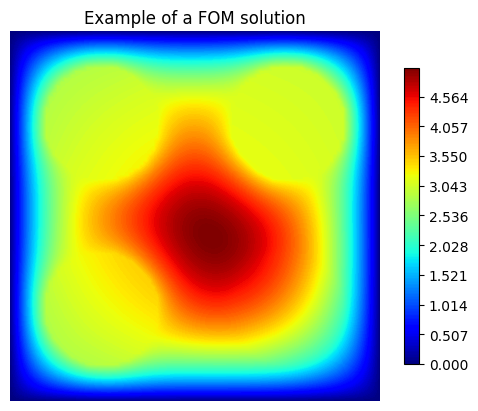

In [ ]:
fe.plot(u[20], Vh, colorbar = True)
plt.title("Example of a FOM solution")
plt.show()

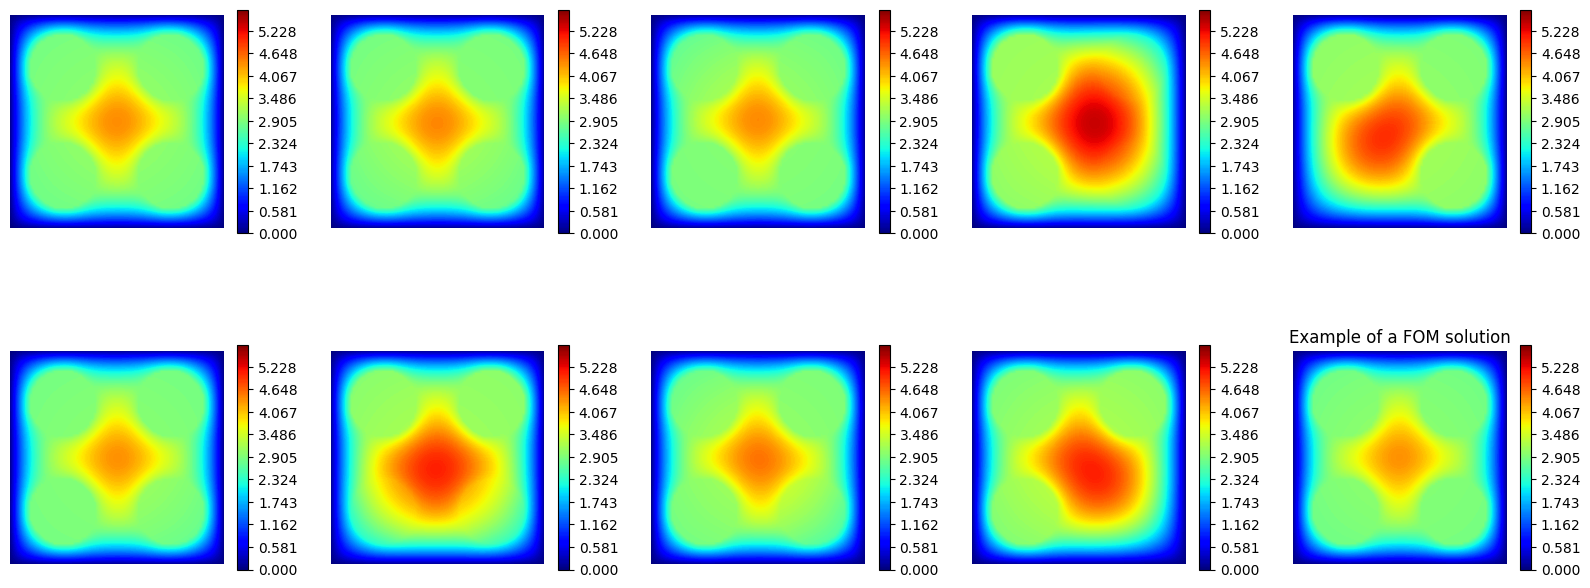

In [ ]:
fe.multiplot(u[:10],(2,5), Vh, vmin = u.min(),vmax = u.max(), colorbar = True)
plt.title("Example of a FOM solution")
plt.show()

# The RB method in a nutshell

The idea is to replace (1) with a smaller system, obtained by substituting the FOM space, $V_{h}$, with a smaller one, $V_{rb}\subset V_{h}$. To see how this works, let $\mathbf{V}\in\mathbb{R}^{N_{h}\times n}$ be an orthogonal matrix, representing a suitable basis of $V_{rb}$, where $\text{dim}(V_{rb})=n$. Let

$$\mathbf{A}_{\boldsymbol{\mu}}^{rb}:= \mathbf{V}^{\top}\mathbf{A}_{\boldsymbol{\mu}}\mathbf{V},\quad\quad \mathbf{f}^{rb}_{\boldsymbol{\mu}}:=\mathbf{V}^{\top}\mathbf{f}_{\boldsymbol{\mu}}.$$

Then, it is straight forward to see that the $n\times n$ system below

$$\begin{equation}\tag{2}\mathbf{A}_{\boldsymbol{\mu}}^{rb}\mathbf{c}^{rb}=\mathbf{f}^{rb}_{\boldsymbol{\mu}},\end{equation}$$

is nothing but the projection of (1) onto the reduced space $V_{rb}$. Equivalently, we are considering a Galerkin projection of the PDE onto the RB space, rather than onto the Finite Element space.

Thus, an RB solver works as follows. Given a parameter instance $\boldsymbol{\mu}$,

1. Assemble $\mathbf{A}_{\boldsymbol{\mu}}^{rb}$ and $\mathbf{f}_{\boldsymbol{\mu}}^{rb}$;

2. Solve (2), retriving $\mathbf{c}^{rb}=\mathbf{c}^{rb}_{\boldsymbol{\mu}}\in\mathbb{R}^{n}$;

3. Convert the RB solution, from RB notation to FOM notation (change of basis):

$$\mathbf{u}^{rb}_{\boldsymbol{\mu}} := \mathbf{V}\mathbf{c}^{rb}_{\boldsymbol{\mu}}.$$

Operatively, an RB solver, must address the following questions:

Q1: how do we choose a suitable RB space?

Q2: how do we assemble the reduced system efficiently?

## 1. Proper Orthogonal Decomposition (POD)

In order to pick a suitable basis, we look for possible matrices $\mathbf{V}$ for which
$$\mathbf{u}_{\boldsymbol{\mu}}\approx \mathbf{V}\mathbf{V}^{\top}\mathbf{u}_{\boldsymbol{\mu}}.$$

In practice, this can be achieved by collecting a random sample of PDE solutions and performing a suitable truncated Singular Value Decomposition (SVD). Let $\mathbf{u}_{i}:=\mathbf{u}_{\boldsymbol{\mu}_{i}}$. We run the FOM solver $N$ times to collect $N$ different simulations
$[\mathbf{u}_{1},\dots, \mathbf{u}_{N}]$,
each one associated to a random parameter instance $\boldsymbol{\mu}_{i}$.

Then, we can collect all the simulations in a matrix (called **snapshots matrix**)
$$\mathbf{U}_{\text{train}}=[\mathbf{u}_{1},\dots, \mathbf{u}_{N}]\in\mathbb{R}^{N_{h}\times N}$$

of which we perform an SVD decomposition,

$$\mathbf{X}\mathbf{S}\mathbf{Y}^{\top}=\mathbf{U}_\text{train}.$$

Here, $\mathbf{S}=\text{diag}(s_{1},\dots, s_{N})$ are the singular values of $\mathbf{U}$, listed in decreasing order.

The idea is to define $\mathbf{V}$ by extracting the first $n$ columns of $\mathbf{X}$. This procedure is called **Proper Orthogonal Decomposition**.


<mark>**Exercise 1**</mark></br>
Split the 100 simulations into a training set of size $N=50$ and a test set of size $N_{\text{test}}=50$.

 Leveraging on the function $\texttt{svd}$ in the $\texttt{scipy.linalg}$ package, compute the SVD of the snapshots matrix $\mathbf{U}_\text{train}$.

1. Plot the singular values $s_{1},s_{2},\dots,s_{N}$. Given the decay of the singular values, pick a suitable reduced dimension $n$. NB: what happens if you exclude $s_{1}$ when doing the plot?

2. Construct the POD matrix $\mathbf{V}$ and plot the first three basis functions.

3. What is the average projection error entailed by the POD space? Compute it by evaluating the formula below</br></br>
$$E_{\text{proj}}=\frac{1}{N_{\text{test}}}\sum_{i=1}^{N_\text{test}}\frac{|\mathbf{u}_{i}^{\text{test}}-\mathbf{V}\mathbf{V}^{\top}\mathbf{u}_{i}^{\text{test}}|}{|\mathbf{u}_{i}^{\text{test}}|}$$</br>where $\mathbf{u}_{i}^{\text{test}}$ are the simulations in the test set.


In [ ]:
from scipy.linalg import svd

U = u.T #snapshot matrix
N_train = 50
N_test = 50
U_train = U[:,:N_train]
U_test = U[:,N_train:]


X, S, Yt = svd(U_train,full_matrices = False)




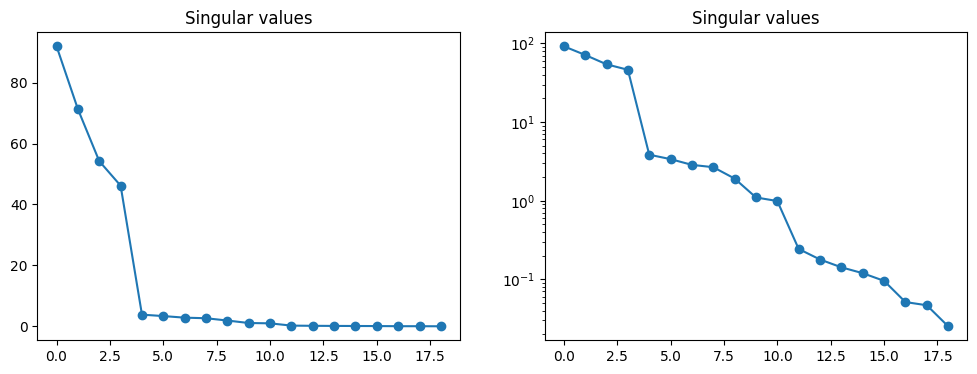

In [ ]:
# 1. Plotting the singular values
plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plt.plot(S[1:20],marker = 'o')
plt.title("Singular values")
plt.subplot(1,2,2)
plt.semilogy(S[1:20],marker = 'o')
plt.title("Singular values")
plt.show()




In [ ]:
# 2. POD matrix
n_reduced=10
V = X[:,:n_reduced]





In [ ]:
V.shape

(10201, 10)

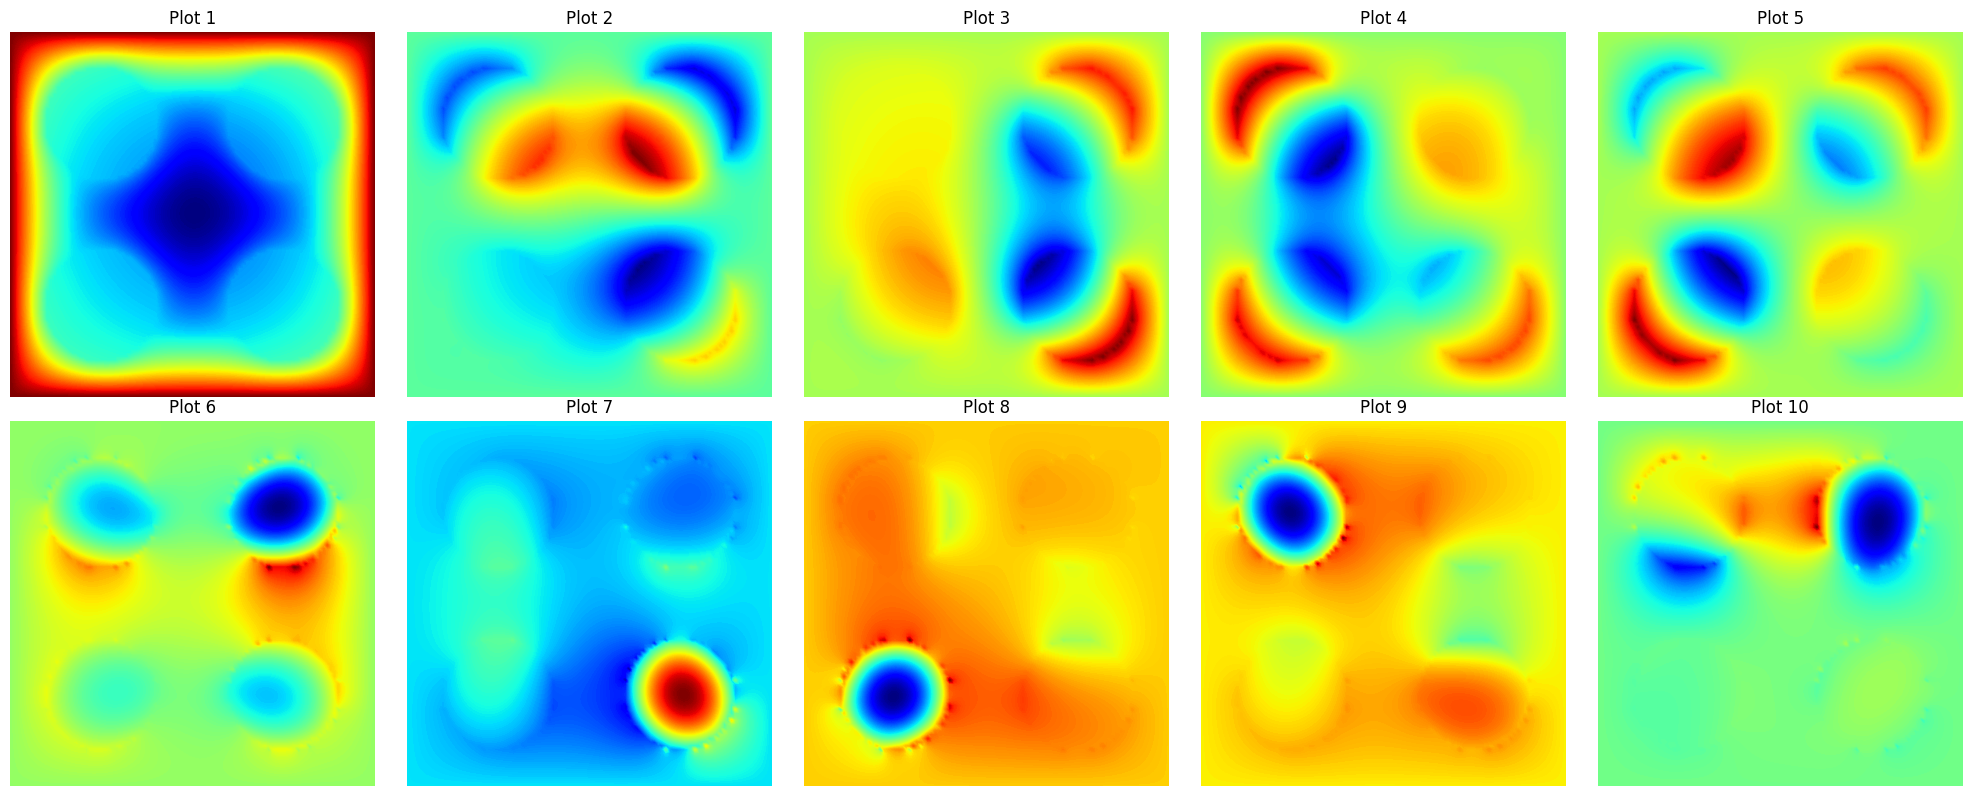

In [ ]:
plt.figure(figsize=(20, 8))  # Define one figure for all subplots

for i in range(10):
    plt.subplot(2, 5, i + 1)  # Create a subplot in a 1-row, 5-column grid
    fe.plot(V[:, i], Vh)  # Your plotting function
    plt.title(f"Plot {i+1}")  # Optional: Add titles for clarity

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

By combining these five with the right weights it is possible to reconst the follwoing solution

u = a1 v1+a2 v2+a3 v3+a4 v4+a5 v5

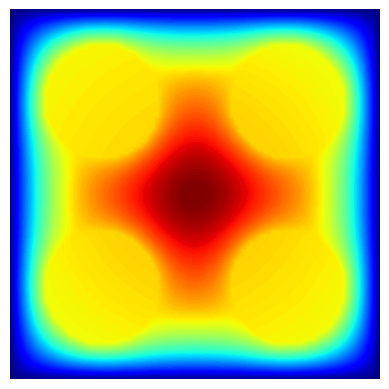

In [ ]:
fe.plot(u[0], Vh)
plt.show()

In [ ]:
V.T@u[0]

array([-2.64998393e+02, -4.14504259e+00,  7.72711041e+00,  6.62087874e+00,
        1.89415778e+00, -4.55253792e-02,  6.26633124e-02,  7.30698022e-02,
       -1.38535856e-01,  1.57356858e-01])

In [ ]:
(V.T@U_train.T[0]).shape

(10,)

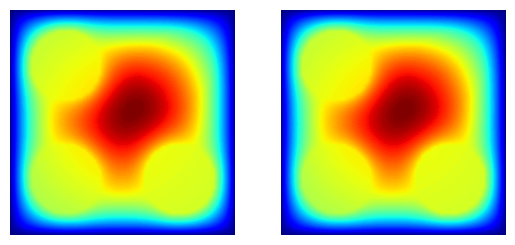

In [ ]:
u_approxm = V@(V.T@U_train[:,10])

plt.subplot(1,2,1)
fe.plot(u[10], Vh)

plt.subplot(1,2,2)
fe.plot(u_approxm, Vh)
plt.show()

In [ ]:
(U_train[:,:3]).shape

(10201, 3)

In [ ]:
V.T.shape

(10, 10201)

In [ ]:
V.T@U_test

array([[-2.80534166e+02, -3.16488547e+02, -2.70506328e+02,
        -2.94900033e+02, -2.69757784e+02, -2.68072340e+02,
        -2.80204939e+02, -2.77041747e+02, -3.01450098e+02,
        -2.73281711e+02, -2.96006690e+02, -2.76260784e+02,
        -2.80166119e+02, -2.81496896e+02, -2.68405252e+02,
        -3.17140384e+02, -2.68626790e+02, -2.84531553e+02,
        -2.72657559e+02, -2.62136490e+02, -2.93528706e+02,
        -2.80284353e+02, -2.81569323e+02, -2.81572083e+02,
        -2.78687911e+02, -2.86276221e+02, -3.15722767e+02,
        -3.04329420e+02, -3.13662676e+02, -2.65240305e+02,
        -3.15375965e+02, -2.70454718e+02, -2.81295266e+02,
        -2.84443628e+02, -2.77885998e+02, -3.03137001e+02,
        -2.89200246e+02, -2.87473734e+02, -2.66945483e+02,
        -2.85575989e+02, -2.74450090e+02, -2.66445818e+02,
        -2.66334543e+02, -2.82386892e+02, -2.64297473e+02,
        -2.64260693e+02, -2.73513735e+02, -2.90389880e+02,
        -2.93648154e+02, -3.08795036e+02],
       [ 1.57

In [ ]:
# 3. Projection error
from dlroms import num2p

us_test_approxm=V @ (V.T @ U_test)
us_test_approxm.shape

(10201, 50)

In [ ]:
(U_test-us_test_approxm)
np.mean(np.abs(U_test-us_test_approxm),axis=0)

array([0.00161512, 0.01260527, 0.00248372, 0.00078923, 0.00143106,
       0.00124551, 0.00102074, 0.00205974, 0.00331746, 0.0010311 ,
       0.00199418, 0.00240894, 0.00214998, 0.00311085, 0.0014863 ,
       0.00317643, 0.00115441, 0.00189566, 0.00124798, 0.00049038,
       0.00140978, 0.00149257, 0.00234538, 0.00148684, 0.00254833,
       0.00186904, 0.00569168, 0.00583444, 0.00740948, 0.00079416,
       0.00157219, 0.00166698, 0.00151261, 0.00101771, 0.00054456,
       0.00221593, 0.00315553, 0.00097182, 0.00059996, 0.0017935 ,
       0.00162029, 0.00085861, 0.00149324, 0.0019511 , 0.00060159,
       0.00051079, 0.00345775, 0.00149151, 0.00235081, 0.00314874])

## 2. Assembling the ROM (affine case)

Even with the POD matrix at hand, assembling the ROM can be highly nontrivial. Luckily, things become fairly simple in the case of affinely-parametrized operators. In fact, assume that

$$\mathbf{A}_{\boldsymbol{\mu}}=\mathbf{A}_{0}+\sum_{j=1}^{p}\mu_{j}\mathbf{A}_{j}$$

for some fixed $\mathbf{A}_{0},\dots,\mathbf{A}_{p}$. For simplicity, say that $\mathbf{f}_{\boldsymbol{\mu}}=\mathbf{f}$ is constant in $\boldsymbol{\mu}$. Then, we can pre-compute

- $\mathbf{f}_{\boldsymbol{\mu}}^{rb}:=\mathbf{V}^{\top}\mathbf{f}$;

- $\mathbf{A}_{j}^{rb}:=\mathbf{V}^{\top}\mathbf{A}_{j}\mathbf{V}$ for $j=0,\dots,p$.

Then, during the "online phase", given a parameter instance $\boldsymbol{\mu}$, assembling $\mathbf{A}_{\boldsymbol{\mu}}^{rb}$ boils down to computing
</br>
$$\mathbf{A}_{\boldsymbol{\mu}}^{rb}=\mathbf{A}_{0}^{rb}+\sum_{j=1}^{p}\mu_{j}\mathbf{A}_{j}^{rb}.$$

<mark>**Exercise 2**</mark></br>
Pre-compute $\mathbf{f}_{\boldsymbol{\mu}}^{rb}$ and $\mathbf{A}_{j}^{rb}$ for $j=0,\dots,p$. Then, construct a function called $\texttt{assembleROM}$ that, given $\boldsymbol{\mu}\in\mathbb{R}^{p}$ returns $\mathbf{A}_{\boldsymbol{\mu}}^{rb}$ and $\mathbf{f}_{\boldsymbol{\mu}}^{rb}$.


In [ ]:
from dlroms.testcases.cookies import A_out, A0, A1, A2, A3, fh

A_out_re=V.T@A_out@V
A0_re  = V.T@A0@V
A1_re  = V.T@A1@V
A2_re  = V.T@A2@V
A3_re  = V.T@A3@V
fh_re  = V.T@fh

In [ ]:
A0_re.shape

(10, 10)

In [ ]:
def assembleROM(mu):
  xi = mu**2
  Arb = A_out_re + xi[0]*A0_re + xi[1]*A1_re + xi[2]*A2_re + xi[3]*A3_re
  frb = fh_re
  return Arb, frb

## 3. Let's try this out!

<mark>**Exercise 3**</mark></br>
Construct a function called $\texttt{RBsolver}$ that, given $\boldsymbol{\mu}\in\mathbb{R}^{p}$ returns the RB solution $\mathbf{u}_{\boldsymbol{\mu}}^{rb}$ in FOM coordinates.

1. Let $\boldsymbol{\mu}_{0}:=[0.2, 0.01, 1, 0.4]$. Compare FOM and ROM solutions (plot, relative error, etc.).

2. How fast is the ROM compared to the FOM?

3. What is the average relative error of the ROM across the whole test set?


In [ ]:
def RBsolver(mu):

  A_rb,f_rb = assembleROM(mu)
  c_rb = np.linalg.solve(A_rb,f_rb)
  urb = V@c_rb
  return urb

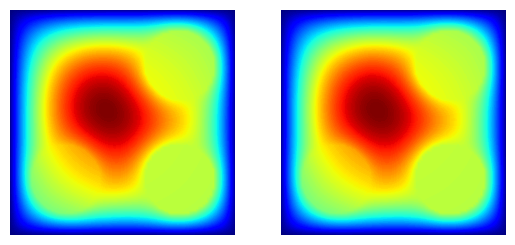

In [ ]:
# 1. Comparison for a specific mu

mu = np.array([0.2, 0.01, 1, 0.4])
u_rb = RBsolver(mu)
u = FOMsolver(mu)

plt.subplot(1,2,1)
fe.plot(u, Vh)

plt.subplot(1,2,2)
fe.plot(u_rb, Vh)
plt.show()





In [ ]:
# 2. Time complexity
from time import perf_counter

# timing each solver
tic = perf_counter()
u_rb = RBsolver(mu)
toc = perf_counter()
time_rb = toc - tic
print(f"Time taken by RB solver: {time_rb} seconds")
tic = perf_counter()
u = FOMsolver(mu)
toc = perf_counter()
time_fom = toc - tic
print(f"Time taken by FOM solver: {time_fom} seconds")


Time taken by RB solver: 0.0005430990004242631 seconds
Time taken by FOM solver: 0.37658417399961763 seconds


In [ ]:
#3. Test error




